In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow_probability as tfp
import ipywidgets as widgets
import seaborn as sns
from IPython.display import display
from tqdm.autonotebook import tqdm
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import sys
print(f'Using Python={sys.version}')
print(f'Using Tensorflow={tf.__version__}')
print(f'Using Keras={keras.__version__}')
print("GPU Available: ", tf.test.is_gpu_available())


/home/alan/projects/venv-jupyter/lib/python3.7/site-packages/pandas/compat/__init__.py:84: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/home/alan/projects/venv-jupyter/lib/python3.7/site-packages/pandas/compat/__init__.py:84: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/home/alan/projects/venv-jupyter/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


Using Python=3.7.2 (default, Mar 30 2019, 15:56:42) 
[GCC 5.4.0 20160609]
Using Tensorflow=2.1.0
Using Keras=2.2.4-tf
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available:  False


In [9]:
class VectorSpreadAlgorithm:
    def __init__(self, n_vec, dims=2, learning_rate=0.01, lr_decay=0.995, clip_norm=None):
        self.n_vec = n_vec
        self.vecs = np.random.normal(size=(n_vec, dims))
        self.norm_rows_inplace()
        self.spread_hist = []
        self.fig, self.ax = plt.subplots(figsize=(6,6))
        self.learning_rate = learning_rate
        self.lr_decay = lr_decay
        self.clip_norm = clip_norm
    
    
    def norm_rows_inplace(self):
        # 0.999 guarantees values < 1.000 which causes NaNs in tf.acos
        self.vecs = 0.999 * keras.utils.normalize(self.vecs, axis=1)

    @staticmethod
    def spread_metric(tfvecs):
        raise NotImplementedError('This must be overridden in derived class')
        
    
    def plot_vecs(self, ax=None, title=None):
        if ax is None:
            ax = self.ax
            
        ax.set_xlim(-1.2, 1.2)
        ax.set_ylim(-1.2, 1.2)
        ax.set_aspect('equal')
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        
        if title:
            ax.set_title(title)
        
        vec_xs = np.zeros(2*self.vecs.shape[0])
        vec_ys = np.zeros(2*self.vecs.shape[0])
        vec_xs[::2] = self.vecs[:, 0]
        vec_ys[::2] = self.vecs[:, 1]
        
        lines, = ax.plot(vec_xs, vec_ys, 'b-')
        red_pts = ax.scatter([0], [0], s=100, c='red')
        green_pts = ax.scatter(self.vecs[:, 0], self.vecs[:, 1], s=13.3, c='green')
            
        return lines, red_pts, green_pts
    
    
    def init_axes(self):
        self.ax.set_xlim(-1.2, 1.2)
        self.ax.set_ylim(-1.2, 1.2)
        self.ax.set_aspect('equal')
        self.ax.grid(False)
        self.ax.set_xticks([])
        self.ax.set_yticks([])
        self.line_data, = self.ax.plot([],[],'b-')
        self.red_pt_data = self.ax.scatter([0],[0], c='red', s=100)
        self.green_pt_data = self.ax.scatter([],[], c='green', s=15)
        return self.line_data, self.red_pt_data, self.green_pt_data
        
        
    def update_plot_data(self, i):
        self.one_iter(i)
        
        vec_xs = np.zeros(2*self.vecs.shape[0])
        vec_ys = np.zeros(2*self.vecs.shape[0])
        vec_xs[::2] = self.vecs[:, 0]
        vec_ys[::2] = self.vecs[:, 1]
        
        self.line_data.set_data(vec_xs, vec_ys)
        self.red_pt_data.set_offsets(np.zeros(shape=(1,2), dtype='float32'))
        self.green_pt_data.set_offsets(self.vecs)
            
        return self.line_data, self.red_pt_data, self.green_pt_data
    
    
    def one_iter(self, i):
        self.norm_rows_inplace()
        tfvecs = tf.convert_to_tensor(self.vecs, dtype=tf.float32)

        with tf.GradientTape() as tape:
            tape.watch(tfvecs)
            spread = self.spread_metric(tfvecs)

        grads = tape.gradient(spread, tfvecs)
        
        if self.clip_norm:
            grads = tf.clip_by_norm(grads, self.clip_norm)
            
        self.vecs += self.learning_rate * grads.numpy()
        self.spread_hist.append(spread.numpy())
        self.norm_rows_inplace()
        if (i+1) % 100 == 0:
            self.learning_rate *= self.lr_decay
            
        
    def run_animation_code(self, file_out, n_iter, interval_ms=5):
        anim = animation.FuncAnimation(self.fig,
                                       func=self.update_plot_data,
                                       init_func=self.init_axes,
                                       frames=n_iter,
                                       interval=interval_ms,
                                       blit=True)
        anim.save(file_out)
        


In [3]:
class VectorSpread_MaxMinAngle(VectorSpreadAlgorithm):
    @staticmethod
    def spread_metric(tensor2d):
        """
        This method should use tf.* methods to compute a quantity to maximize
        Assumes all rows already normalized
        """
        angle_pairs = tf.acos(tensor2d @ tf.transpose(tensor2d))
        disable_diag = tf.eye(tensor2d.numpy().shape[0]) * 2 * np.pi
        to_maximize = tf.reduce_min(angle_pairs + disable_diag)    
        return to_maximize
    

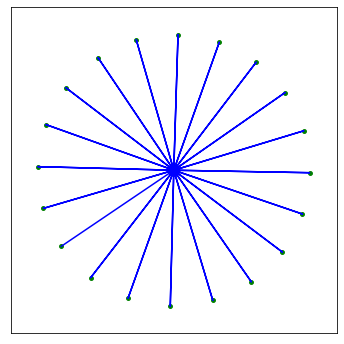

In [4]:
vs = VectorSpread_MaxMinAngle(20, learning_rate=0.01)
vs.run_animation_code(file_out='min_min.mp4', n_iter=5000)


In [5]:
class VectorSpread_MaxMinAngle_with_Variance(VectorSpread_MaxMinAngle):
    def spread_metric(self, tensor2d):
        """ Assumes all rows already normalized """
        angle_pairs = tf.acos(tensor2d @ tf.transpose(tensor2d))
        disable_diag = tf.eye(tensor2d.numpy().shape[0]) * 2 * np.pi
        all_mins = tf.reduce_min(angle_pairs + disable_diag, axis=1)    
        
        # We want to maximize the min-min angle, as before
        min_min = tf.reduce_min(all_mins)
        
        # Additionally subtract the variance of the set of minimum angles.  Our target
        # configuration should have all vectors with the same minimum-angle neighbor.
        avg_min = tf.reduce_mean(all_mins)
        var_min = tf.reduce_sum(tf.square(all_mins - avg_min))
        
        # Use 
        coef_min = 0.7
        coef_var = 0.3
        to_maximize = coef_min * min_min - coef_var * var_min
        
        return to_maximize

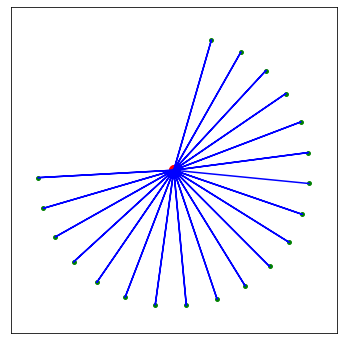

In [6]:
vs = VectorSpread_MaxMinAngle_with_Variance(20, learning_rate=0.01)
vs.run_animation_code(file_out='min_min_w_var.mp4', n_iter=5000)

In [7]:
class VectorSpread_Force(VectorSpreadAlgorithm):
    
    def calc_force_a_onto_b(self, vec_a, vec_b):
        diff = vec_b - vec_a
        norm = tf.sqrt(tf.reduce_sum(diff**2))
        force_vec = diff / norm**3

        # Project force vector onto this vec, calculate how much is radial
        b_dot_f = tf.tensordot(vec_b, force_vec, axes=1)
        b_dot_b = tf.tensordot(vec_b, vec_b, axes=1)
        radial_component =  (b_dot_f / b_dot_b) * vec_b

        # Subtract radial component, calculate resulting magnitude
        return force_vec - radial_component
            
    
    def spread_metric(self, tensor2d):
        """ Assumes all rows already normalized """
        n_vec = tensor2d.numpy().shape[0]
        
        all_force_list = []
        for this_idx in range(n_vec):
            
            # Accumulate force contribution of all other vecs onto this one
            this_force_list = []
            
            for other_idx in range(n_vec):
                
                if this_idx == other_idx:
                    continue

                this_vec = tensor2d[this_idx, :]
                other_vec = tensor2d[other_idx, :]
                
                tangent_force_vec = self.calc_force_a_onto_b(other_vec, this_vec)
                this_force_list.append(tangent_force_vec)
            
            # We now have a list of all N-dimensional force vecs.  Stack and sum
            sum_tangent_forces = tf.reduce_sum(tf.stack(this_force_list))
            this_force_magnitude = tf.sqrt(tf.reduce_sum(sum_tangent_forces**2))
            
            # Accumulate all magnitudes, which should all be zero at optimal solution
            all_force_list.append(this_force_magnitude)
            
        # More force = less spread, so change sign (so it's still a maximization problem)
        to_maximize = -tf.reduce_sum(tf.stack(all_force_list))
        return to_maximize
    
    
    def one_iter(self, i):
        self.norm_rows_inplace()
        tfvecs = tf.convert_to_tensor(self.vecs, dtype=tf.float32)

        with tf.GradientTape() as tape:
            tape.watch(tfvecs)
            spread = self.spread_metric(tfvecs)

        grads = tape.gradient(spread, tfvecs)
        grads = tf.clip_by_norm(grads, 200.0)
        self.vecs += self.learning_rate * grads.numpy()
        self.spread_hist.append(spread.numpy())
        self.norm_rows_inplace()
        if (i+1) % 100 == 0:
            self.learning_rate *= self.lr_decay       
    


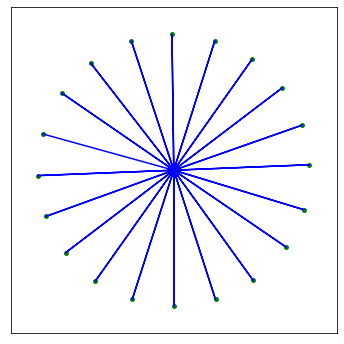

In [8]:
# This version should converge on a solution very quickly.  Use less iterations and high LR decay
vs = VectorSpread_Force(20, learning_rate=0.001, lr_decay=0.7)
vs.run_animation_code(file_out='force_solution_clip.mp4', n_iter=500, interval_ms=20)

-----

-----

In [ ]:
vs = VectorSpread(20)
n_iter = 10000
fig,ax = plt.subplots(figsize=(7,7))
learning_rate = 0.01
os.makedirs('images_2d', exist_ok=True)


vs.norm_rows_inplace()
for j in range(n_iter+1):
    vs.one_iter(j, learning_rate=0.01)
    ax.clear()
    if j % 50 == 0:
        vs.plot_vecs(ax=ax)
        fig.savefig(os.path.join('images_2d', f'img_{j:05d}.png'))
        learning_rate *= 0.995
        

#anim = animation.FuncAnimation(fig, animate, frames=n_iter//10, interval=10, fargs=[vs, n_iter])
#anim.save('test_out.mp4')

In [ ]:
import imageio


In [ ]:
anim.save('test_out.mp4')

In [75]:
vecs = np.random.normal(size=(6, 3)).astype('float32')
print(vecs)
vecs = keras.utils.normalize(vecs, axis=1)
vecs = keras.utils.normalize(vecs, axis=1)
vecs = keras.utils.normalize(vecs, axis=1)
vecs = keras.utils.normalize(vecs, axis=1)
print(vecs, np.sum(vecs*vecs, axis=1))


[[-0.6195256   0.6008991   1.0285556 ]
 [-0.7740193   1.4527676  -1.1056768 ]
 [-0.51428103  0.6062217  -1.3821576 ]
 [-1.8884108   0.64826936  0.16387096]
 [ 1.6934814   0.7927521   0.82772326]
 [ 0.20431028  1.0704391  -0.3082893 ]]
[[-0.46140605  0.44753352  0.7660406 ]
 [-0.3903338   0.732623   -0.5575869 ]
 [-0.3225395   0.38020155 -0.86684203]
 [-0.9426511   0.3236011   0.0818006 ]
 [ 0.82816416  0.38768     0.40478197]
 [ 0.18040162  0.9451749  -0.27221286]] [1.        1.0000001 1.0000001 1.0000001 1.0000001 1.0000001]


In [ ]:
vecs = np.random.normal(size=(20, 3)).astype('float32')
learning_rate = 0.005
min_angle_collect = []
eps = 0.01
n_iter = 10000

print(vecs)

for i in range(n_iter):
    #vecs = tf.linalg.normalize(vecs, axis=1)[0]
    vecs = keras.utils.normalize(vecs, axis=1)
    print(vecs)
    
    if i%(n_iter / 10) == 0:
        # Reduce learning-rate and plot current state
        #learning_rate *= 0.98
        plot_vecs_3d(vecs)
        

    tfvecs = tf.convert_to_tensor(vecs, dtype=tf.float32)

    with tf.GradientTape() as tape:
        tfvar = tf.Variable(tfvecs)
        spread = spread_metric(tfvar)
        min_angle_collect.append(spread)
        
    grads = tape.gradient(spread, tfvar)
    vecs += learning_rate * grads.numpy()
    
vecs = keras.utils.normalize(vecs, axis=1)

In [ ]:
fig,ax = plt.subplots(1,1, figsize=(5,4))
ax.plot(min_angle_collect)
ax.set_xlabel('Iterations')
ax.set_ylabel('Minimum angle')
ax.set_title('Maximizing the minimum angle size')

